In [1]:
# -*- coding: utf-8 -*-

In [2]:
from __future__ import division
from IPython.display import Audio

In [3]:
%matplotlib inline
from IPython.display import display

In [4]:
# import io
# from nbformat import current

# def execute_notebook(nbfile):
    
#     with io.open(nbfile) as f:
#         nb = current.read(f, 'json')
    
#     ip = get_ipython()
    
#     for cell in nb.worksheets[0].cells:
#         if cell.cell_type != 'code':
#             continue
#         ip.run_cell(cell.input)

In [5]:
# execute_notebook("speechutils.ipynb")

In [6]:
%run "speechutils.py"

In [7]:
%run "viewutils.ipynb"

In [8]:
ch = callhome_eval_init("config.json", fast=False)

../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/master_graph.nodes
Loading prep state dictionary ...
Finished loading prep state dictionary ...
Finished ...
Finished - reading nodes ...
Processing line: 1
Finished - reading edges ...
Removing duplicates in pairs list
Set length: 19438 and List length: 43061
Generating vocabulary of English words ... 
Finished vocab ...
Generating initial belief over English translations
Processed 1 nodes
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Generating similarity between nodes based on English translations ...
Finished generating similarity ...
Processing line: 1
Processing line: 3001
Processing line: 6001
Processing line: 9001
Processing line: 12001
Processing line: 15001
Processing line: 18001
Total matches: 19438
matches with missing transcriptions: 0
matches with only sil, sp: 8986
Finished - evaluating 19438 pairs ...
Setting up eval data frame
Finished ...
Savi

In [9]:
df_zrt, cols_to_show = ch.gen_zrt_df()

# Analyse ZRT output

### Set up visualizations

In [10]:
pd.options.display.float_format = '{:,.3f}'.format

In [11]:
display(df_zrt.head(3))
display(df_zrt[cols_to_show].head(10))

,chid1,chid2,cnt_es_w_check,ES cont match,dur,en_w_cnt_count_sim_0,EN sim,en_w_count_sim_0,en_w_hgr_sim_0,ES phone edit sim,...,n1,n2,no_mtch,sil_only,uid1,uid2,ZRT,sim mixed,spk1,spk2
0,1,1,False,0,550,0,0.000,1,0.037,0.571,...,1,2,False,False,049.003,049.007,0.882,0.794,1.049.003,1.049.007
1,1,1,False,0,580,1,0.047,1,0.089,0.286,...,2,64,False,False,049.007,049.073,0.903,0.817,1.049.007,1.049.073
2,1,1,True,0,520,0,0.000,1,0.037,0.167,...,3,4,False,False,049.003,049.007,0.872,0.785,1.049.003,1.049.007


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
0,1,2,0.882,LíNEAS Y ESTABA,QUE ESTáN,0,0.571,0,0.000,0.794,1.049.003,1.049.007
1,2,64,0.903,QUE ESTáN,EH sp A LO,0,0.286,0,0.047,0.817,1.049.007,1.049.073
2,3,4,0.872,MIRA ES QUE ESTOY,PUEDE DECIR SEXPERCIOS,0,0.167,0,0.000,0.785,1.049.003,1.049.007
3,5,6,0.883,AQUí EN UN TELéFONO,QUé NO APARECEN,0,0.364,0,0.000,0.795,1.049.003,1.049.044
4,6,126,0.861,QUé NO APARECEN,REFERENCIAS Y LOS DATOS,0,0.200,0,0.054,0.780,1.049.044,1.049.054
5,6,714,0.879,QUé NO APARECEN,VI EN LA PRENSA,0,0.545,0,0.000,0.791,1.049.044,2.050.067
6,6,716,0.866,QUé NO APARECEN,Y NO APAREZCAN,1,0.636,0,0.000,0.779,1.049.044,2.050.138
7,6,718,0.877,QUé NO APARECEN,AYUDO A QUERERTE,0,0.364,0,0.000,0.789,1.049.044,2.051.118
8,6,728,0.868,QUé NO APARECEN,LLAMé PARA ACá,0,0.182,0,0.000,0.781,1.049.044,1.056.241
9,7,8,0.852,EH QUE sp TIENE,ESTE SEAN,0,0.222,0,0.000,0.767,1.049.003,1.049.057


## Pairs discovered

### Filter Pairs

In [12]:
# Pairs with no matches in ES transcripts or only ['sil','sp'] matches
df_no_mtch_sil_only = df_zrt[(df_zrt['no_mtch'] == True) | (df_zrt['sil_only'] == True)]
# Pairs only ['sil','sp'] matches
df_sil_only = df_zrt[(df_zrt['sil_only'] == True)]
# Pairs with no matches in ES transcripts, but no ['sil','sp'] detected
df_no_mtch_not_sil = df_zrt[(df_zrt['no_mtch'] == True) & (df_zrt['sil_only'] == False)]

# Pairs with ES words found for both nodes
df_valid = df_zrt[(df_zrt['no_mtch'] == False) & (df_zrt['sil_only'] == False)]

# Filtering two files:
# df_valid = df_valid[df_valid.apply(lambda row: remove_invalid_files(row), axis=1)]
# df_valid = df_valid[df_valid['dur'] > 600]

# out_t = PrettyTable(["Description", "# of pairs"], hrules=True)
out_t = PrettyTable(["Description", "# of pairs"])
out_t.align['Description'] = 'r'
out_t.add_row(["Total pairs", len(df_zrt)])
out_t.add_row(["With sil, sp, or no matches", len(df_no_mtch_sil_only)])
out_t.add_row(["Pairs with speech segments and ES words", len(df_valid)])
print(out_t)
print(out_t.get_html_string())

+-----------------------------------------+------------+
|                             Description | # of pairs |
+-----------------------------------------+------------+
|                             Total pairs |   19438    |
|             With sil, sp, or no matches |    8986    |
| Pairs with speech segments and ES words |   10452    |
+-----------------------------------------+------------+
<table>
    <tr>
        <th>Description</th>
        <th># of pairs</th>
    </tr>
    <tr>
        <td>Total pairs</td>
        <td>19438</td>
    </tr>
    <tr>
        <td>With sil, sp, or no matches</td>
        <td>8986</td>
    </tr>
    <tr>
        <td>Pairs with speech segments and ES words</td>
        <td>10452</td>
    </tr>
</table>


## Histogram - ZRT values

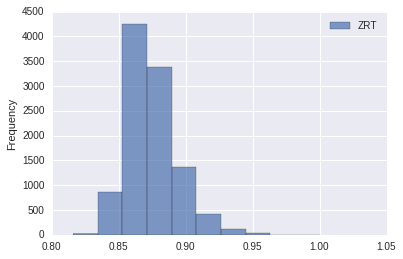

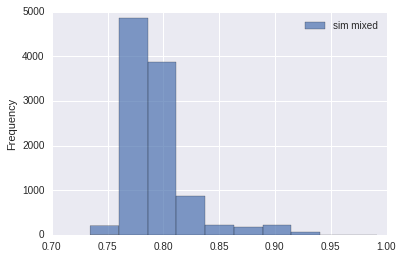

In [13]:
df_valid[['ZRT']].plot(kind='hist', alpha=0.7)
df_valid[['sim mixed']].plot(kind='hist', alpha=0.7)

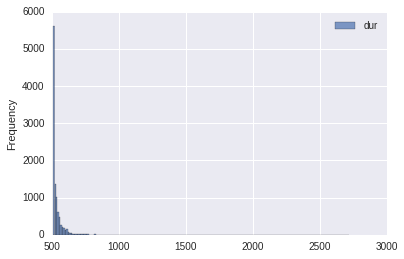

In [14]:
df_valid[['dur']].plot(kind='hist', alpha=0.7, bins=200)

## Correlation between DTW and other metrics

In [ ]:
display(df_valid[['ZRT', 'EN sim']].corr())
display(df_valid[['ZRT', 'ES phone edit sim']].corr())
display(df_valid[['ZRT', 'ES cont match']].corr())
display(df_valid[['ZRT', 'ES word match']].corr())
display(df_valid[['ES phone edit sim', 'ES word match']].corr())

# Long matches

In [15]:
long_dur_ms = 800
df_long_dur = df_valid[df_valid['dur'] >= long_dur_ms]
print("# of pairs with duration >= %dms : %d" % (long_dur_ms, len(df_long_dur)))
df_long_dur[cols_to_show].head(10)

# of pairs with duration >= 800ms : 63


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
34,45,46,0.908,DIFíCILES POR EJEMPLO,FILóCTETES POR EJEMPLO P,1,0.857,1,0.092,0.826,1.049.007,1.049.014
3376,619,620,0.913,SIMPLEMENTE EXPONGO,SIMPLEMENTE,1,0.846,1,0.069,0.829,1.049.040,1.049.062
4624,1291,1292,0.925,sp AL sp DIECIOCHO,sil DEL DOCE AL DIECIOCHO,1,0.438,1,0.216,0.854,1.049.073,1.049.078
5118,1761,1762,0.933,ACTA DE BAUTISMO sil,ACTA DE BAUTISMO sil,1,1.000,1,0.119,0.852,1.049.142,1.049.152
5119,1763,1764,0.925,MI ACTA DE BAUTISMO,MI ACTA DE BAUTISMO,1,1.000,1,0.196,0.852,1.049.142,1.049.154
6506,2541,2542,0.943,BUENO sp sil,BICI,0,0.000,0,0.082,0.857,2.049.182,1.059.018
8476,3299,3300,0.934,sil NS AJá,CLASES NS sil,1,0.250,1,0.000,0.841,2.049.217,2.060.122
8571,3445,3446,0.932,Y YA LE HABLAMOS A,Y YA LE HABLAMOS,1,0.923,1,0.000,0.932,1.049.223,1.049.223
10251,5767,5768,0.929,RESPONDE sp,LA sp,0,0.333,0,0.000,0.836,2.050.034,2.050.048
11773,10443,10444,0.931,YO NO ME sp YO NO ME,YO NO ME sp YO NO ME,1,1.000,0,0.000,0.931,1.050.159,1.050.159


In [81]:
nodes_table = PrettyTable(["Node id", "Speech file", \
                           "Start time(ms)", \
                           "End time(ms)"])
transcripts_table = PrettyTable(["Node id", "ES words", \
                           "ES content words"])

scores_table = PrettyTable(["Pair id", "Node 1", "Node 2", "DTW score", "ES content word match"])


for i in range(1,5)+[27, 28, 61, 62, 64, 1761,1762]:
    nodes_table.add_row([i, ch.node_dict[i].wav_fil+".wav", ch.node_dict[i].start, \
                        ch.node_dict[i].end])
    #print((' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')))
    es_w = (' '.join(ch.node_dict[i].es_words).decode('utf-8'))
    if ch.node_dict[i].es_cnt_words:
        es_cnt_w = (' '.join(ch.node_dict[i].es_cnt_words).decode('utf-8')).strip()
    else:
        es_cnt_w = '---'
    #print(i, set(ch.node_dict[i].es_cnt_words) - set(['sil', 'sp']))
    es_w = es_w.replace('sil', '').replace('sp', '')
    es_cnt_w = es_cnt_w.replace('sil', '').replace('sp', '')
    transcripts_table.add_row([i, es_w, es_cnt_w])

found = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if found == 10:
        break
    if pair['cnt_es_w_sim'] > 0 or i<=2:
        scores_table.add_row([i, pair['n1'], pair['n2'], pair['zrt_sim'], pair['cnt_es_w_sim']])
        found += 1

print(nodes_table)
print(transcripts_table)
print(scores_table)
#print(' '.join(ch.node_dict[2].es_words))


display(ch.eval_pairs_list[1])
found = 0
for i, pair in enumerate(ch.eval_pairs_list):
    if pair['zrt_sim'] >= 0.88 and len(pair['es_w_n1'].split()) == 2 \
    and pair['en_w_hgr_sim_0'] == 0 \
    and pair['sil_only'] == False \
    and pair['es_w_n1'] != 'sil AS\xed':
        print(i, pair['n1'], pair['n2'], \
              pair['es_w_n1'].decode('utf-8'), pair['es_w_n2'].decode('utf-8'),\
             pair['cnt_es_w_sim'])
        found += 1
        if found == 50:
            break
print(found)

+---------+-------------+----------------+--------------+
| Node id | Speech file | Start time(ms) | End time(ms) |
+---------+-------------+----------------+--------------+
|    1    | 049.003.wav |      356       |     411      |
|    2    | 049.007.wav |      371       |     434      |
|    3    | 049.003.wav |       53       |     105      |
|    4    | 049.007.wav |      758       |     811      |
|    27   | 049.003.wav |      572       |     623      |
|    28   | 060.030.wav |      226       |     277      |
|    61   | 049.007.wav |      144       |     201      |
|    62   | 049.073.wav |       20       |      75      |
|    64   | 049.073.wav |      263       |     321      |
|   1761  | 049.142.wav |      177       |     267      |
|   1762  | 049.152.wav |      279       |     372      |
+---------+-------------+----------------+--------------+
+---------+------------------------+------------------------+
| Node id |        ES words        |    ES content words    |
+-----

{'chid1': 1,
 'chid2': 1,
 'cnt_es_w_check': False,
 'cnt_es_w_sim': 0,
 'dur': 580,
 'en_w_cnt_count_sim_0': 1,
 'en_w_cnt_hgr_sim_0': 0.04734583016931315,
 'en_w_count_sim_0': 1,
 'en_w_hgr_sim_0': 0.08917934209687683,
 'es_p_sim': 0.2857142857142857,
 'es_w_n1': 'QUE EST\xc3\xa1N',
 'es_w_n2': 'EH sp A LO',
 'es_w_sim': 0,
 'n1': 2,
 'n2': 64,
 'no_mtch': False,
 'sil_only': False,
 'uid1': '049.007',
 'uid2': '049.073',
 'zrt_sim': 0.903}

(352, 160, 190, u'sil AS\xed', u'sp HASTA', 0)
(374, 160, 606, u'sil AS\xed', u'TE QUEREMOS sil', 0)
(386, 160, 1248, u'sil AS\xed', u'sil AH', 0)
(393, 160, 2340, u'sil AS\xed', u'sil BIEN', 0)
(432, 160, 2706, u'sil AS\xed', u'sp BIEN', 0)
(435, 160, 2920, u'sil AS\xed', u'sil S\xed C\xf3MO', 0)
(439, 160, 2938, u'sil AS\xed', u'SIETE', 0)
(440, 160, 2940, u'sil AS\xed', u'sil PERO', 0)
(453, 160, 3320, u'sil AS\xed', u'sil CHILE', 0)
(478, 160, 4256, u'sil AS\xed', u'STRIPPERS sp', 0)
(958, 176, 30879, u'PURIFICADORES DE', u'DE sp DESDE', 0)
(990, 188, 444, u'sp AL\xf3', u'AC\xe1 LG sil', 0)
(999, 188, 2340, u'sp AL\xf3', u'sil BIEN', 0)
(1000, 188, 2466, u'sp AL\xf3', u'PERO', 0)
(1008, 188, 3968, u'sp AL\xf3', u'DIRECCI\xf3N', 0)
(1038, 190, 606, u'sp HASTA', u'TE QUEREMOS sil', 0)
(1040, 190, 1190, u'sp HASTA', u'ESO sp ESO', 0)
(1041, 190, 1194, u'sp HASTA', u'sil LG BUENO', 0)
(1046, 190, 1248, u'sp HASTA', u'sil AH', 0)
(1048, 190, 1674, u'sp HASTA', u'REFORMISTA', 0)
(1050, 1

In [16]:
display(Audio(ch.play_pair_wav(34)))
display(Audio(ch.play_pair_wav(5119)))

Playing evaluation pair id: 34
Pair text details
+---------+--------------------------+----------------------------------------------------+
| node id |      ES transcript       |                   EN translation                   |
+---------+--------------------------+----------------------------------------------------+
|    45   |  DIFíCILES POR EJEMPLO   | eh look i wanna tell you something there are some  |
|         |                          |    there are some things that are difficult for    |
|         |                          |  instance in english you cant say sexpercios how   |
|         |                          |                    you call it                     |
+---------+--------------------------+----------------------------------------------------+
|    46   | FILóCTETES POR EJEMPLO P | and mm how would you say how would would you spell |
|         |                          |           filoctetes for instance p h i            |
+---------+--------------------

Playing evaluation pair id: 5119
Pair text details
+---------+---------------------+----------------------------------------+
| node id |    ES transcript    |             EN translation             |
+---------+---------------------+----------------------------------------+
|   1763  | MI ACTA DE BAUTISMO | to tell them to send me my baptism act |
+---------+---------------------+----------------------------------------+
|   1764  | MI ACTA DE BAUTISMO |        my sacrament of baptism         |
+---------+---------------------+----------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.925       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+--------------------------------

In [78]:
display(ch.play_node_wav(619))
display(ch.play_node_wav(620))
display(ch.play_node_wav(45))
display(ch.play_node_wav(46))

node_1_file = ch.play_node_wav(1761)
node_2_file = ch.play_node_wav(1762)
display(node_1_file)
display(node_2_file)
# display(ch.play_node_source_wav(76605))

Playing node id: 619
Transcript + Translation details
+---------+---------------------+------------------------------------------------+
| node id |    ES transcript    |                 EN translation                 |
+---------+---------------------+------------------------------------------------+
|   619   | SIMPLEMENTE EXPONGO | in in where where simply i expose what you are |
|         |                     |                   saying and                   |
+---------+---------------------+------------------------------------------------+
Node details
+---------+------------+--------+-----------+---------+---------+
| node id | uttrnce id | spk id | start(ms) | end(ms) | dur(ms) |
+---------+------------+--------+-----------+---------+---------+
|   619   |  049.040   |   1    |    2080   |   2910  |   830   |
+---------+------------+--------+-----------+---------+---------+


u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n619.wav'

Playing node id: 620
Transcript + Translation details
+---------+---------------+----------------------------------------------------+
| node id | ES transcript |                   EN translation                   |
+---------+---------------+----------------------------------------------------+
|   620   |  SIMPLEMENTE  | a general conclusion can not be based simply on on |
|         |               |   on right data but it has to have a right logic   |
|         |               |  whose final interpretation depends on the final   |
|         |               | opinion of the experts group so i want to put that |
|         |               |                       clear                        |
+---------+---------------+----------------------------------------------------+
Node details
+---------+------------+--------+-----------+---------+---------+
| node id | uttrnce id | spk id | start(ms) | end(ms) | dur(ms) |
+---------+------------+--------+-----------+---------+---------+
|   62

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n620.wav'

Playing node id: 45
Transcript + Translation details
+---------+-----------------------+---------------------------------------------------+
| node id |     ES transcript     |                   EN translation                  |
+---------+-----------------------+---------------------------------------------------+
|    45   | DIFíCILES POR EJEMPLO | eh look i wanna tell you something there are some |
|         |                       |    there are some things that are difficult for   |
|         |                       |  instance in english you cant say sexpercios how  |
|         |                       |                    you call it                    |
+---------+-----------------------+---------------------------------------------------+
Node details
+---------+------------+--------+-----------+---------+---------+
| node id | uttrnce id | spk id | start(ms) | end(ms) | dur(ms) |
+---------+------------+--------+-----------+---------+---------+
|    45   |  049.007   |   1    

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n45.wav'

Playing node id: 46
Transcript + Translation details
+---------+--------------------------+----------------------------------------------------+
| node id |      ES transcript       |                   EN translation                   |
+---------+--------------------------+----------------------------------------------------+
|    46   | FILóCTETES POR EJEMPLO P | and mm how would you say how would would you spell |
|         |                          |           filoctetes for instance p h i            |
+---------+--------------------------+----------------------------------------------------+
Node details
+---------+------------+--------+-----------+---------+---------+
| node id | uttrnce id | spk id | start(ms) | end(ms) | dur(ms) |
+---------+------------+--------+-----------+---------+---------+
|    46   |  049.014   |   1    |    6630   |   7430  |   800   |
+---------+------------+--------+-----------+---------+---------+


u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n46.wav'

Playing node id: 1761
Transcript + Translation details
+---------+----------------------+----------------------------------------+
| node id |    ES transcript     |             EN translation             |
+---------+----------------------+----------------------------------------+
|   1761  | ACTA DE BAUTISMO sil | to tell them to send me my baptism act |
+---------+----------------------+----------------------------------------+
Node details
+---------+------------+--------+-----------+---------+---------+
| node id | uttrnce id | spk id | start(ms) | end(ms) | dur(ms) |
+---------+------------+--------+-----------+---------+---------+
|   1761  |  049.142   |   1    |    1770   |   2670  |   900   |
+---------+------------+--------+-----------+---------+---------+
Playing node id: 1762
Transcript + Translation details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n1761.wav'

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/n1762.wav'

In [ ]:
plot_dtw(node_1_file, node_2_file)

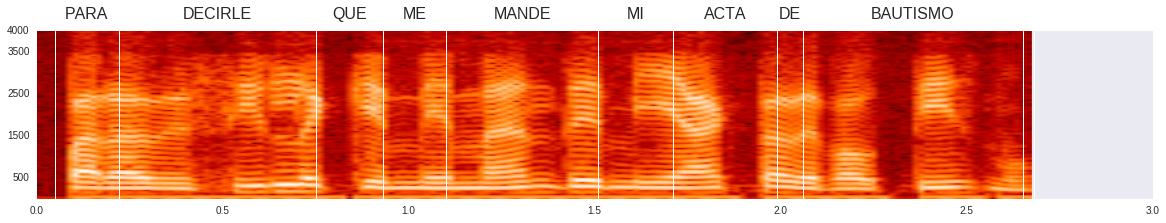

In [80]:
%run viewutils.ipynb
node_id = 1761

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1761.pdf"

plot_specgram_words(target_file, es_words, plot_name)

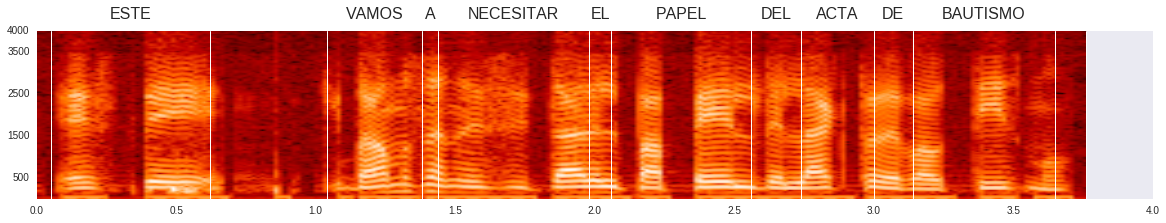

In [79]:
node_id = 1762

node_info = ch.node_dict[node_id]
wav_file = node_info.wav_fil
target_file = ch.file_info_dict[wav_file].target_file+".wav"
es_words = ch.es_words_dict[wav_file]
plot_name = "output/bautismo_1762.pdf"

plot_specgram_words(target_file, es_words, plot_name)

In [27]:
ch.play_pair_wav(5118)

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

u'../../ZRTools/exp/callhome_train_20/matches/config0.80-0.90-0.80-50/wavs/p5118.wav'

DTW distance: 74.035992
[5.0, 62.0, 104.0, 138.0, 144.0, 198.0, 206.0, 256.0, 274.0, 300.0, 314.0, 365.0, 376.0]
[5.0, 22.0, 75.0, 93.0, 110.0, 151.0, 171.0, 199.0, 206.0, 265.0, 268.0]
((177, 267), (279, 372))


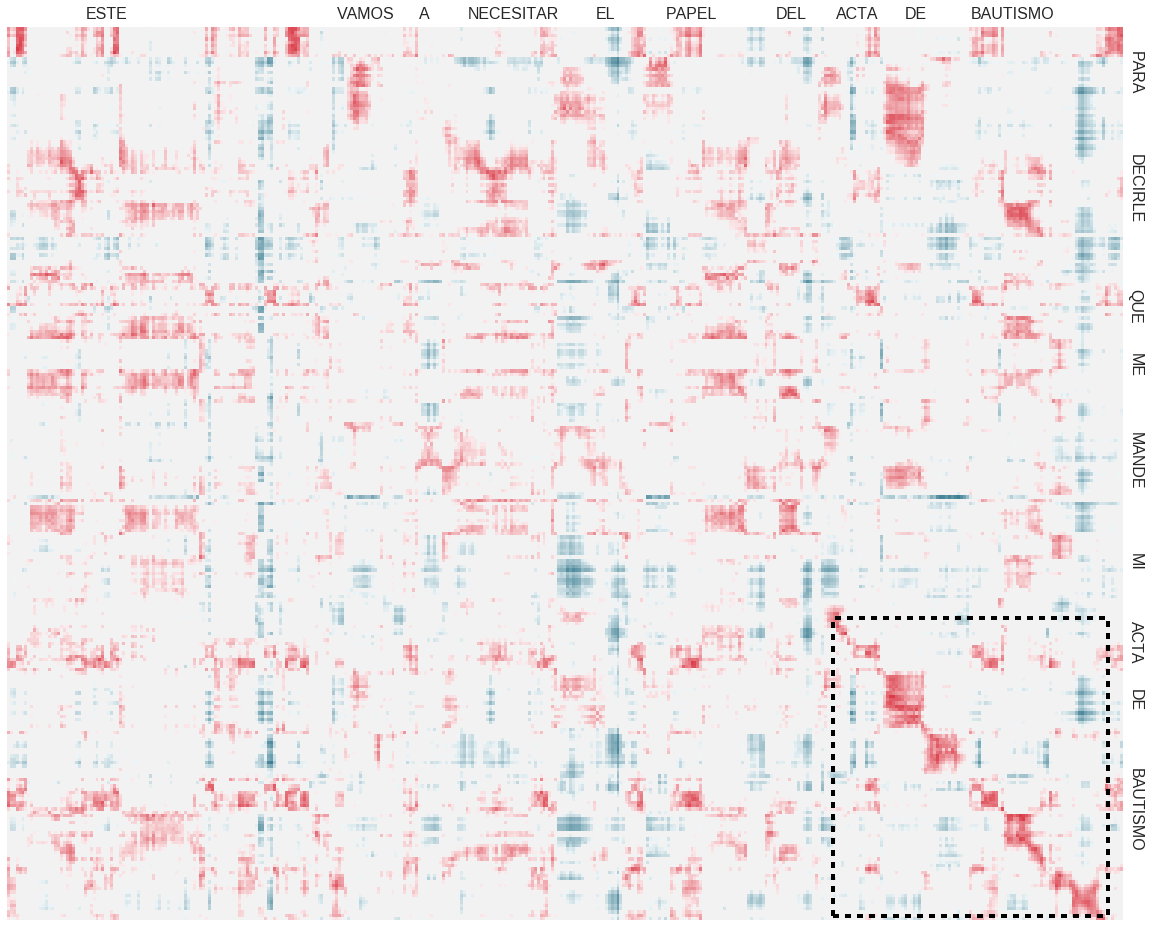

In [76]:
# %run viewutils.ipynb

# node_1 = ch.node_dict[1761]
# node_2 = ch.node_dict[1762]

# wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
# wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

# es_words_1 = ch.es_words_dict[node_1.wav_fil]
# es_words_2 = ch.es_words_dict[node_2.wav_fil]
# plot_name = "output/dtw_pair_1761_1762.pdf"
# # print(wav_1, wav_2)
# # print(es_words_1, es_words_2)
# wav_1_time = (node_1.start, node_1.end)
# wav_2_time = (node_2.start, node_2.end)
# plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
#          wav_1_time, wav_2_time, plot_name)

Playing evaluation pair id: 5118
Pair text details
+---------+----------------------+-----------------------------------------------+
| node id |    ES transcript     |                 EN translation                |
+---------+----------------------+-----------------------------------------------+
|   1761  | ACTA DE BAUTISMO sil |     to tell them to send me my baptism act    |
+---------+----------------------+-----------------------------------------------+
|   1762  | ACTA DE BAUTISMO sil | we are going to need the sacrament of baptism |
|         |                      |                     paper                     |
+---------+----------------------+-----------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.933       |
+-----------------

DTW distance: 74.035992
[5.0, 62.0, 104.0, 138.0, 144.0, 198.0, 206.0, 256.0, 274.0, 300.0, 314.0, 365.0, 376.0]
[5.0, 22.0, 75.0, 93.0, 110.0, 151.0, 171.0, 199.0, 206.0, 265.0, 268.0]
((177, 267), (279, 372))


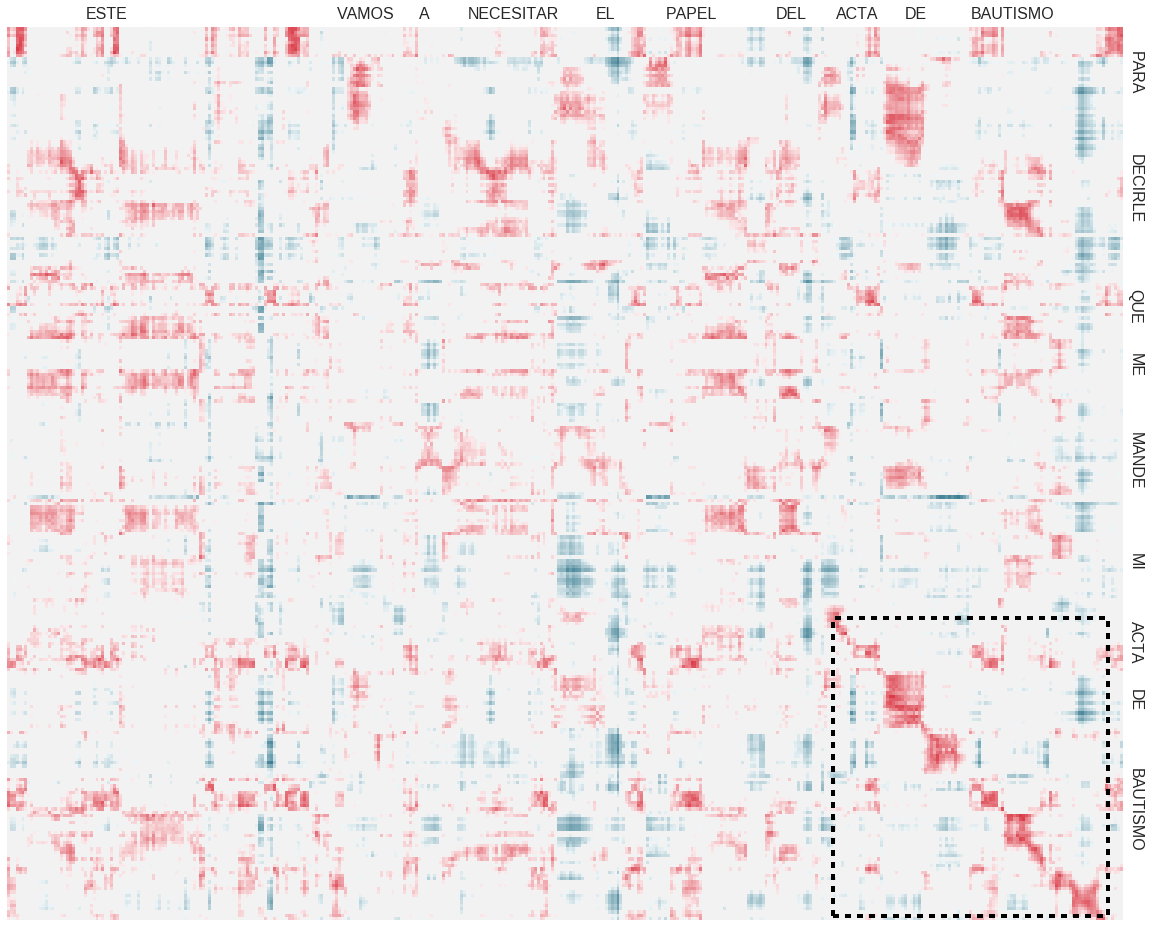

In [95]:
display_pair_and_plot_dtw(5118, tosave=False)

Playing evaluation pair id: 15944
Pair text details
+---------+----------------------+----------------------------------+
| node id |    ES transcript     |          EN translation          |
+---------+----------------------+----------------------------------+
|  33935  | ENTONCES YA NO PUEDE | not now now then he cant anymore |
+---------+----------------------+----------------------------------+
|  33936  |      BUENO PUES      |   yes well its good well yeah    |
+---------+----------------------+----------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.881       |
+----------------------------------------+------------------+
|         ES content* word match         |        0         |
+----------------------------------------+------------------+
|    

DTW distance: 80.872231
[3.0, 32.0, 71.0, 114.0, 148.0, 173.0, 182.0]
[5.0, 39.0, 52.0, 80.0, 133.0, 143.0, 154.0, 199.0, 204.0, 209.0]
((128, 187), (92, 145))


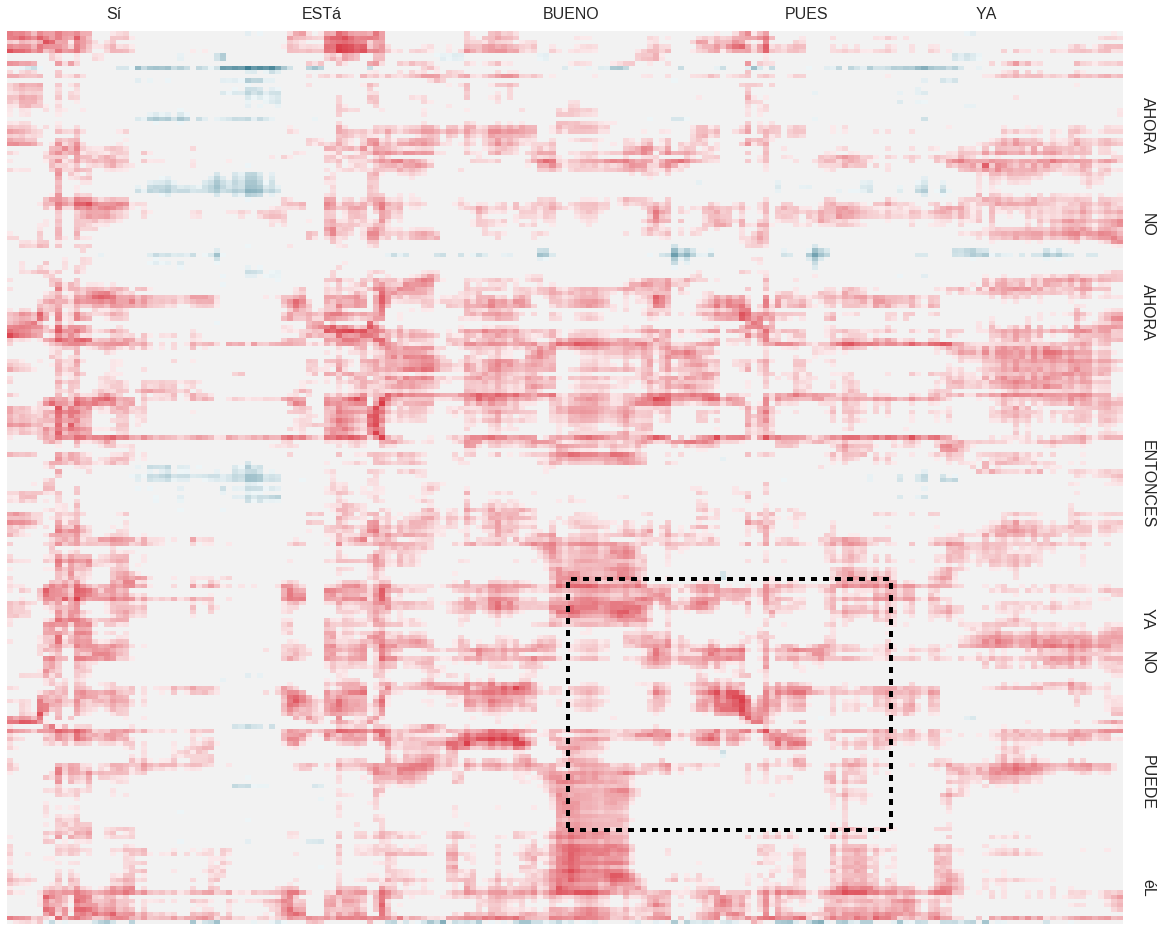

In [105]:
display_pair_and_plot_dtw(15944, tosave=True)

Playing evaluation pair id: 16848
Pair text details
+---------+----------------+------------------------------------------------+
| node id | ES transcript  |                 EN translation                 |
+---------+----------------+------------------------------------------------+
|  44099  | MIL DOSCIENTOS | okay this the address two thousand two hundred |
+---------+----------------+------------------------------------------------+
|  44100  | MIL DOSCIENTOS |            two thousand two hundred            |
+---------+----------------+------------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.864       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+----------

DTW distance: 78.918770
[44.0, 85.0, 124.0, 199.0, 229.0]
[7.0, 31.0, 55.0, 82.0, 91.0, 148.0, 163.0, 191.0, 269.0, 271.0]
((181, 232), (109, 167))


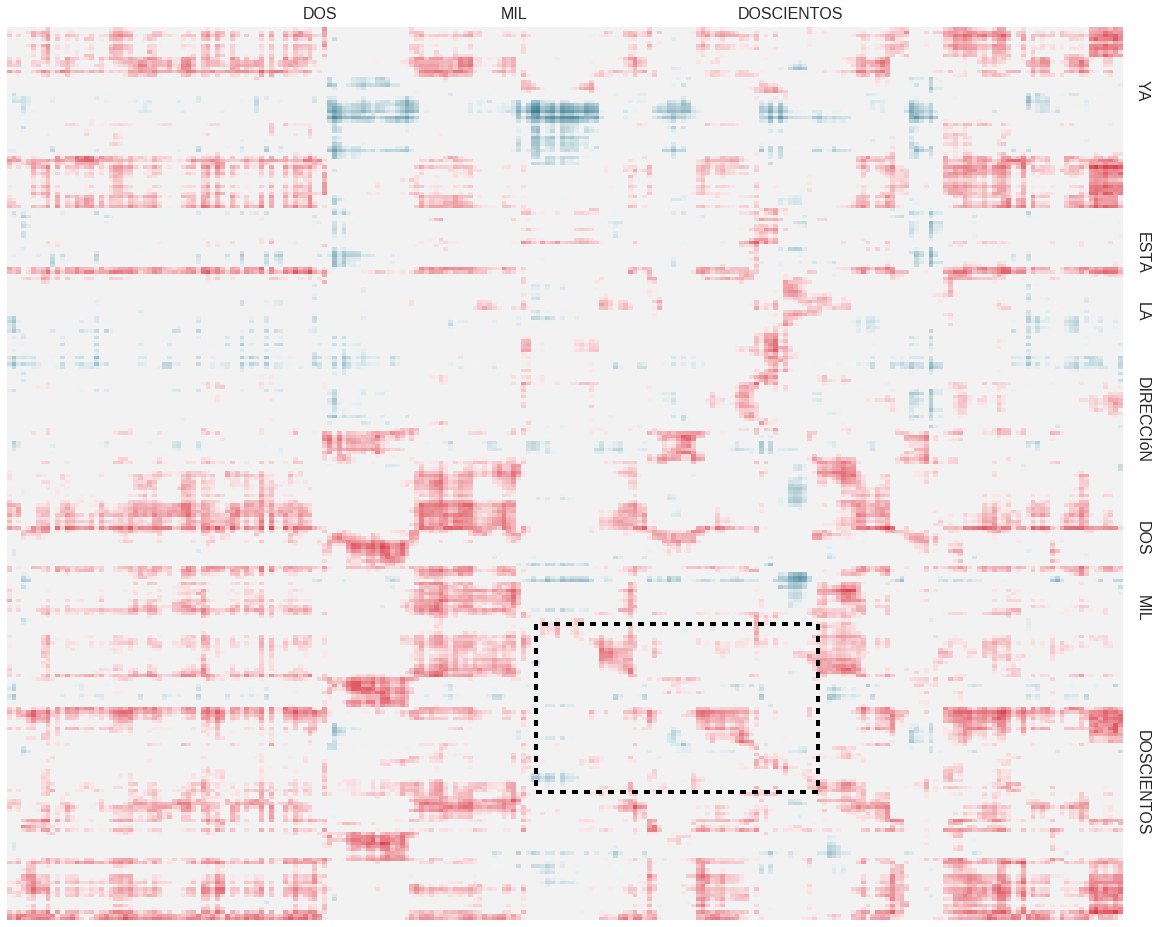

In [106]:
display_pair_and_plot_dtw(16848, tosave=True)

Playing evaluation pair id: 19326
Pair text details
+---------+---------------+-------------------------------------+
| node id | ES transcript |            EN translation           |
+---------+---------------+-------------------------------------+
|  81217  |  sil GRACIAS  |       thanks son very kind ah       |
+---------+---------------+-------------------------------------+
|  81218  |  sil GRACIAS  | thanks eh pretty janecita very kind |
+---------+---------------+-------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.875       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+----------------------------------------+------------------+
|             ES word match      

DTW distance: 66.551691
[2.0, 62.0, 77.0, 143.0, 172.0, 227.0, 231.0, 295.0, 303.0, 309.0]
[2.0, 60.0, 82.0, 101.0, 143.0, 150.0, 155.0, 162.0]
((2, 56), (2, 56))


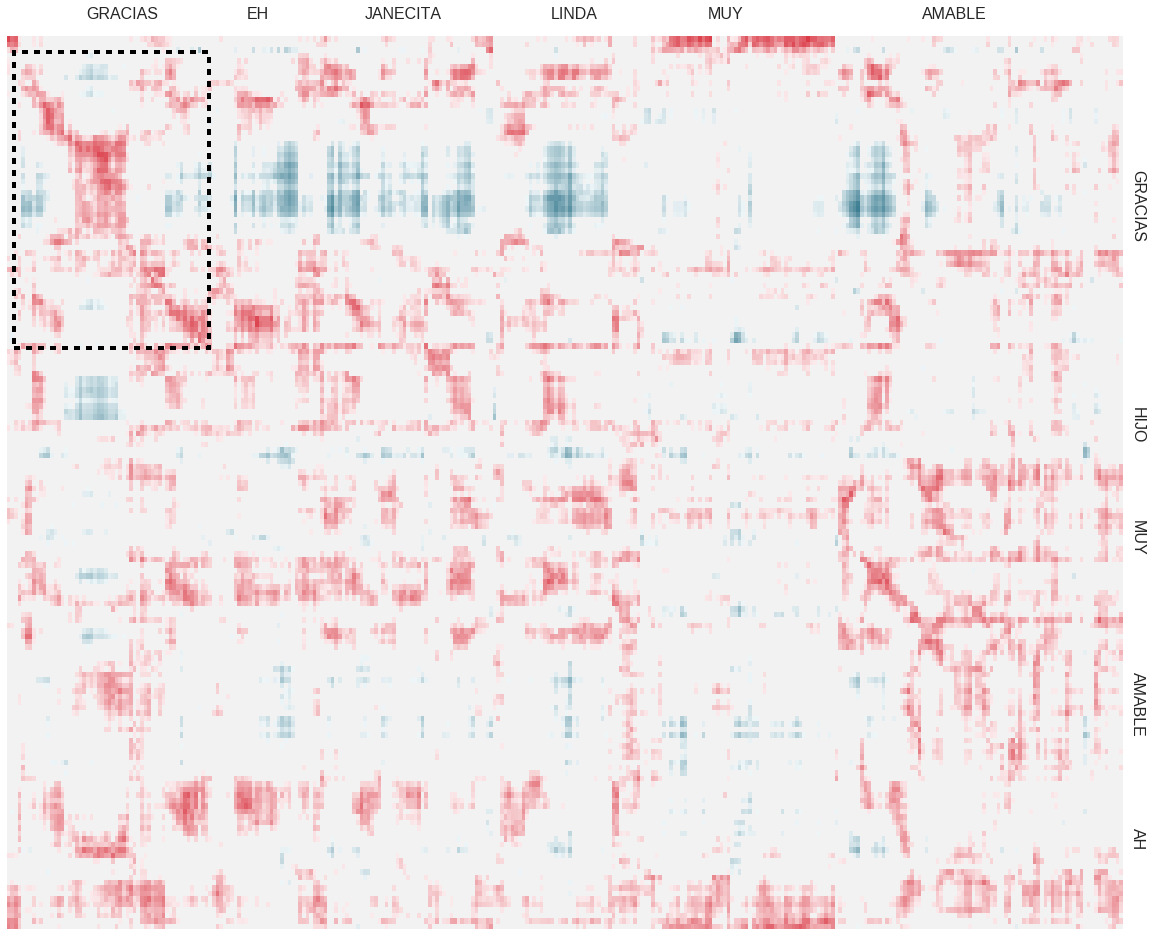

In [100]:
display_pair_and_plot_dtw(19326, tosave=False)

In [101]:
def display_pair_and_plot_dtw(pair_id, tosave=False):
    display(Audio(ch.play_pair_wav(pair_id)))

    pair_info = ch.eval_pairs_list[pair_id]
    node_1 = ch.node_dict[pair_info['n1']]
    node_2 = ch.node_dict[pair_info['n2']]


    wav_1 = ch.file_info_dict[node_1.wav_fil].target_file+".wav"
    wav_2 = ch.file_info_dict[node_2.wav_fil].target_file+".wav"

    es_words_1 = ch.es_words_dict[node_1.wav_fil]
    es_words_2 = ch.es_words_dict[node_2.wav_fil]
    #plot_name = "output/dtw_pair_1761_1762.pdf"
    # print(wav_1, wav_2)
    # print(es_words_1, es_words_2)
    wav_1_time = (node_1.start, node_1.end)
    wav_2_time = (node_2.start, node_2.end)
    plot_name = "output/{0:d}.pdf".format(pair_id)
    if not tosave:
        plot_name = ""
        
    plot_dtw(wav_1, wav_2, es_words_1, es_words_2, \
             wav_1_time, wav_2_time, plot_name)

### Transcription error?

Pair id: 94 shows errors in transcriptions. The word "CONSTITUCIóN" has a duration greater than 1 sec in the transcription. This does not match the source audio file.

In [ ]:
display(ch.play_pair_wav(94))
display(ch.play_node_wav(70))
display(ch.play_node_wav(74, detail=True))
# display(ch.play_node_wav(209))
# display(ch.play_node_wav(210))
display(ch.play_node_source_wav(70))

In [ ]:
ch.play_node_source_wav(70)
ch.gen_segment_wav('../../corpora/callhome_es/out/050.048.wav', .12, 1, "t.wav")
IPython.display.Audio("t.wav")

In [ ]:
print(ch.calc_node_overlap(70, 74))

## Phoneme Similarity

For high DTW score pairs, the phone similarity score should be high as well.

Conversely, if phone similarity is very low, the pair may not be a good match.

### High phoneme score

Pairs with high phoneme similarity score: 685


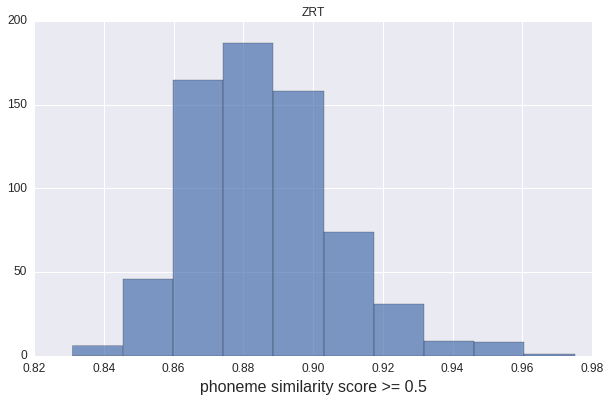

In [64]:
df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.6) \
                            & (df_valid['EN sim'] == 0)]
print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_hi[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score >= 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [81]:
df_phone_score_hi[cols_to_show].head(5)

,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
6,6,716,0.866,QUé NO APARECEN,Y NO APAREZCAN,1,0.636,0,0.000,0.779,1.049.044,2.050.138
26,27,28,0.860,TRABAJO TENGO,TRABAJO QUE TENGA,1,0.833,1,0.000,0.774,1.049.003,1.060.030
43,58,66,0.880,QUE sp AúN,sp EH sp A,0,0.750,0,0.000,0.792,1.049.054,1.049.073
52,66,875,0.874,sp EH sp A,QUE sp AúN,0,0.750,0,0.000,0.787,1.049.073,1.049.054
109,129,130,0.878,FILóCTETES POR EJEMPLO,SORPRESITAS PORQUE ESTOY,0,0.600,0,0.000,0.790,1.049.014,1.049.118


In [82]:
display(Audio(ch.play_pair_wav(75)))

Playing evaluation pair id: 75
Pair text details
+---------+------------------+---------------------------------------------------+
| node id |  ES transcript   |                   EN translation                  |
+---------+------------------+---------------------------------------------------+
|    78   |   INFINITO DE    | thats the plan in the endless help plan and these |
|         |                  | people are offering me to go to mexico but i must |
|         |                  |                   graduate first                  |
+---------+------------------+---------------------------------------------------+
|  10352  | DICIENDO TODO EL |  but uh were telling her all the time maria elena |
|         |                  |                      its just                     |
+---------+------------------+---------------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type            

## Low phoneme score

In [ ]:
df_phone_score_0 = df_valid[(df_valid['ES phone edit sim'] == 0)]
print("Pairs with 0 phoneme similarity score: %d" % len(df_phone_score_0))

f, ax = plt.subplots(figsize=(10, 6))
df_phone_score_0[['ZRT']].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score = 0', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

** Analysis:** The plot shows a lot of high DTW score pairs where there is no match in the phonemes

In [ ]:
df_phone_score_0_high_dtw = df_phone_score_0[df_phone_score_0['ZRT'] > 0.87]
print("Pairs with high DTW and 0 phoneme similarity score: %d" % len(df_phone_score_0_high_dtw))

display(df_phone_score_0_high_dtw[cols_to_show].head(3))
# ch.play_pair_wav(28)

In [ ]:
df_phone_score_0_en_score_0 = df_phone_score_0[df_phone_score_0['EN sim'] == 0]
print("Pairs with 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_en_score_0))
# display(df_phone_score_0_en_score_0[cols_to_show][df_phone_score_0_en_score_0['ZRT'] < 0.82].head(3))
display(df_phone_score_0_en_score_0[cols_to_show].head(3))

df_phone_score_0_high_dtw_en_score_0 = df_phone_score_0_high_dtw[df_phone_score_0_high_dtw['EN sim'] == 0]
print("Pairs with high DTW and 0 phoneme score and 0 EN sim: %d" % len(df_phone_score_0_high_dtw_en_score_0))
display(df_phone_score_0_high_dtw_en_score_0[cols_to_show].head(3))

In [ ]:
# display(ch.play_pair_wav(594, detail=True))
display(ch.play_pair_wav(52, detail=False))
# display(ch.play_node_source_wav(131))

In [ ]:
ch.file_info_dict["049.156"].source_file

In [ ]:
# !soxi ../../corpora/callhome_es/out/006.183.wav
# !play ../../corpora/callhome_es/out/006.183.wav trim 1.24
# IPython.display.Audio("../../corpora/callhome_es/out/tmp/sp_0731_1.wav")

### Conclusion

**Pairs with high DTW and 0 phoneme and 0 EN word similarity indicate transcription errors or coding errors**


**Need to investigate**

### High Phoneme similarity

NameError: name 'df_phone_score_hi' is not defined

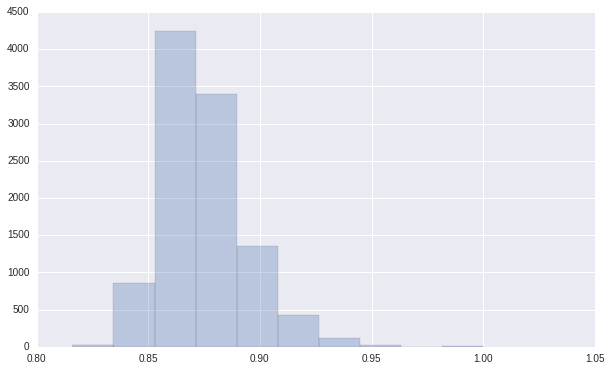

In [19]:
# df_phone_score_hi = df_valid[(df_valid['ES phone edit sim'] >= 0.5)]
# print("Pairs with high phoneme similarity score: %d" % len(df_phone_score_hi))

f, ax = plt.subplots(figsize=(10, 6))
df_valid['ZRT'].hist(ax=ax, alpha=0.3)
df_phone_score_hi['ZRT'].hist(ax=ax, alpha=0.7)
ax.set_xlabel('phoneme similarity score > 0.5', fontsize=16)
# sns.rugplot(df_phone_score_0['ZRT'], color="b", ax=ax)
plt.tick_params(which='both', labelsize=12)
# plt.colorbar(aplot)

In [ ]:
df_phone_score_hi_en_score_0 = df_phone_score_hi[(df_phone_score_hi['EN sim'] == 0) & \
                                                (df_phone_score_hi['spk1'] != df_phone_score_hi['spk2'])]
print("Pairs with high phoneme score and 0 EN sim: %d" % len(df_phone_score_hi_en_score_0))

df_phone_score_hi_en_score_0[cols_to_show].head(5)

In [ ]:
ch.play_pair_wav(70)

## High DTW score, Low EN translation similarity

These are expected to be phonetically similary but semantically different pairs.

**Label Spreading** should help **lower** the DTW score

7532


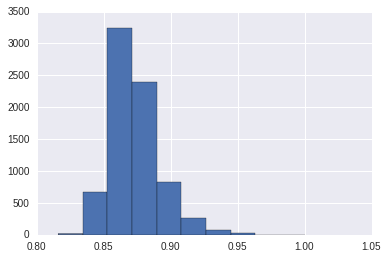

In [45]:
df_valid['ZRT'][(df_valid['EN sim'] == 0)].hist()
print(len(df_valid['ZRT'][(df_valid['EN sim'] == 0)]))

In [46]:
df_high_dtw_0_en = df_valid[(df_valid['ZRT'] > 0.87) \
                            & (df_valid['EN sim'] >= 0.2) & \
                            (df_valid['spk1'] != df_valid['spk2'])]

In [47]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_high_dtw_0_en))
df_high_dtw_0_en[cols_to_show].head(5)

Pairs with high DTW annd 0 EN sim: 308


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
104,119,120,0.896,P H sp,P H Y,1,0.833,1,0.217,0.828,1.049.014,1.049.019
105,121,122,0.882,FILóCTETES,FILOCTETES,0,1.000,0,0.217,0.816,1.049.014,1.049.019
926,166,40236,0.934,sil MMM,sil MMM,1,1.000,1,0.459,0.886,1.062.101,2.051.124
3177,606,3836,0.879,TE QUEREMOS sil,sp BUENO,0,0.000,0,0.216,0.813,1.066.125,1.053.226
4624,1291,1292,0.925,sp AL sp DIECIOCHO,sil DEL DOCE AL DIECIOCHO,1,0.438,1,0.216,0.854,1.049.073,1.049.078


In [48]:
display(Audio(ch.play_pair_wav(105, detail=True)))

Playing evaluation pair id: 105
Pair text details
+---------+---------------+----------------------------------------------------+
| node id | ES transcript |                   EN translation                   |
+---------+---------------+----------------------------------------------------+
|   121   |   FILóCTETES  | and mm how would you say how would would you spell |
|         |               |           filoctetes for instance p h i            |
+---------+---------------+----------------------------------------------------+
|   122   |   FILOCTETES  |   p h and then teta right filoctetes filoctetes    |
+---------+---------------+----------------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.882       |
+----------------------------------

In [ ]:
# !play ../../corpora/callhome_es/out/001.202.wav trim .75 =.99

## Low DTW score, High EN translation similarity

These are expected to be semantically similar but phonetically not very similar.

**Label Spreading** should help **increase** the DTW score

In [ ]:
df_valid['ZRT'][(df_valid['EN sim'] >= 0.2)].hist()

In [ ]:
df_low_dtw_high_en = df_valid[(df_valid['ZRT'] < 0.88) & (df_valid['EN sim'] >= 0.2)]

In [ ]:
print("Pairs with high DTW annd 0 EN sim: %d" % len(df_low_dtw_high_en))
df_low_dtw_high_en[cols_to_show].tail()

In [ ]:
display(Audio(ch.play_pair_wav(19326, detail=True)))

## Precision / Recall

In [ ]:
df_valid[cols_to_show].head()

In [ ]:
ch.play_pair_wav(1)

In [ ]:
ch.eval_precision_recall()

In [ ]:
ch.eval_precision_recall(sim_col='sim mixed')

In [ ]:
ch.plot_precision_recall(both=True)

## Cross-utterance matches

In [39]:
set_speakers_calls = set()
spk1_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk1'].values]
spk2_ids = [s.rsplit('.', 1)[0] for s in df_valid['spk2'].values]
set_speakers_calls |= set(spk1_ids)
set_speakers_calls |= set(spk2_ids)

num_speakers = len(set_speakers_calls)
cross_spk_counts = np.zeros((num_speakers, num_speakers), dtype=np.int)
label2i = {k:i for i, k in enumerate(set_speakers_calls)}
i2label = {i:k for i, k in enumerate(set_speakers_calls)}

for spk1, spk2 in zip(spk1_ids, spk2_ids):
    if spk1 != spk2:
        cross_spk_counts[max(label2i[spk1], label2i[spk2]), min(label2i[spk1], label2i[spk2])] += 1
        cross_spk_counts[min(label2i[spk1], label2i[spk2]), max(label2i[spk1], label2i[spk2])] += 1
    else:
        cross_spk_counts[label2i[spk1], label2i[spk2]] += 1
        pass

print("Total speakers: %d" % num_speakers)

Total speakers: 40


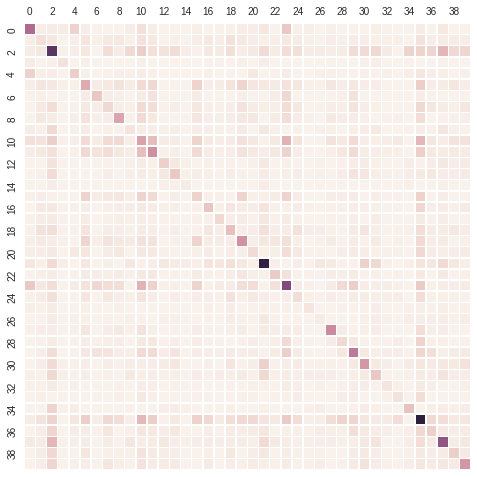

In [40]:
f, ax = plt.subplots(figsize=(8, 8))
cmap = sns.diverging_palette(220, 10, as_cmap=True)

with sns.axes_style("white"):
    ax = sns.heatmap(cross_spk_counts, square=True, annot=False, \
                 fmt="d", linewidths=.5, cbar=False, xticklabels=2, yticklabels=2)
ax.xaxis.tick_top()

In [41]:
# df_valid.columns
df_cross_spkr = df_valid[df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(5))
#df_cross_spkr['ZRT'].hist()

# of cross-speaker pairs: 6512


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
5,6,714,0.879,QUé NO APARECEN,VI EN LA PRENSA,0,0.545,0,0.000,0.791,1.049.044,2.050.067
6,6,716,0.866,QUé NO APARECEN,Y NO APAREZCAN,1,0.636,0,0.000,0.779,1.049.044,2.050.138
7,6,718,0.877,QUé NO APARECEN,AYUDO A QUERERTE,0,0.364,0,0.000,0.789,1.049.044,2.051.118
8,6,728,0.868,QUé NO APARECEN,LLAMé PARA ACá,0,0.182,0,0.000,0.781,1.049.044,1.056.241
19,20,3400,0.856,CONVERTIRSE Y sil,MENOS DE DIEZ MINUTOS,0,0.125,0,0.000,0.770,1.049.218,1.050.103


In [42]:
df_cross_spkr_bad_zrt_good_en = df_cross_spkr[(df_cross_spkr['ZRT'] <= 0.87)\
                                              & (df_cross_spkr['EN sim'] > 0.2)]
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr_bad_zrt_good_en)))
display(df_cross_spkr_bad_zrt_good_en[cols_to_show].head(10))

# of cross-speaker pairs: 13


,n1,n2,ZRT,ES words n1,ES words n2,ES word match,ES phone edit sim,ES cont match,EN sim,sim mixed,spk1,spk2
5162,1845,1848,0.862,BUENO,BUENO MIRA,1,0.429,1,0.293,0.805,2.049.153,2.071.085
8214,3105,3106,0.867,sil PUES Sí sil,PUES Sí EL CASO,1,0.333,1,0.220,0.802,2.049.211,1.058.129
8631,3520,24936,0.856,MEJOR sp Y ESO,PRINCIPIO,0,0.286,0,0.247,0.795,2.060.124,1.054.274
13492,18394,20576,0.861,sil AH,sil AH,1,1.000,1,0.203,0.795,1.059.051,1.061.070
14847,25557,25558,0.859,PEDIR QUE Tú QUIERES,HAGUE Y sp DíGALE QUE,1,0.154,0,0.220,0.795,1.059.155,1.053.251
15408,30019,30020,0.854,sil AH YA,sil AAA,0,0.667,0,0.459,0.814,2.060.200,2.054.052
15409,30023,30024,0.853,AH YA,AH YA sil,1,0.750,1,1.000,0.868,2.060.200,2.065.190
15559,31329,31330,0.854,TODO EL TIEMPO TRABAJANDO,TENíA TIEMPO sp,1,0.538,1,0.216,0.790,1.061.017,1.054.318
16848,44099,44100,0.864,MIL DOSCIENTOS,MIL DOSCIENTOS,1,1.000,1,0.377,0.815,1.063.067,2.063.068
18693,66943,66944,0.865,AH,ESTUVIERON,0,0.000,0,0.211,0.800,2.071.095,2.056.242


In [45]:
display(Audio(ch.play_pair_wav(16848)))

Playing evaluation pair id: 16848
Pair text details
+---------+----------------+------------------------------------------------+
| node id | ES transcript  |                 EN translation                 |
+---------+----------------+------------------------------------------------+
|  44099  | MIL DOSCIENTOS | okay this the address two thousand two hundred |
+---------+----------------+------------------------------------------------+
|  44100  | MIL DOSCIENTOS |            two thousand two hundred            |
+---------+----------------+------------------------------------------------+
Similarity metrics
+----------------------------------------+------------------+
|            Similarity Type             | Similarity Value |
+----------------------------------------+------------------+
|                  ZRT                   |      0.864       |
+----------------------------------------+------------------+
|         ES content* word match         |        1         |
+----------

## Speakers/utterances with most matches

In [ ]:
df_spkr_matches = df_valid.apply(lambda row: row['spk1'].rsplit('.', 1)[0] != \
                                   row['spk2'].rsplit('.', 1)[0], \
                                   axis=1)
print("# of cross-speaker pairs: %d" % (len(df_cross_spkr)))
display(df_cross_spkr[cols_to_show].head(3))
df_cross_spkr['ZRT'].hist()

## s

## Label Spreading - speech pair similarity score update using English translations

In [ ]:
ch.label_prop_edges.label_spread(ch.en_w_hgr_sim_0)

In [ ]:
print(ch.label_prop_edges.belief_0[1])
print(ch.label_prop_edges.belief_n[1])
print(ch.en_w_hgr_sim_0[1], ch.en_w_hgr_sim_0[2])

In [ ]:
df_valid[cols_to_show].sort_values(['ZRT'], ascending=False)

In [ ]:
display(ch.play_pair_wav(84, detail=True))

In [ ]:
(0.9 * 0.8) + (0.1 * 0.7)

In [ ]:
df_valid.columns

In [ ]:
sns.jointplot(x='ZRT', y='ES cont match', data=df_valid, kind='kde')

In [111]:
df_valid.columns

Index([               u'chid1',                u'chid2',
             u'cnt_es_w_check',        u'ES cont match',
                        u'dur', u'en_w_cnt_count_sim_0',
                     u'EN sim',     u'en_w_count_sim_0',
             u'en_w_hgr_sim_0',    u'ES phone edit sim',
                u'ES words n1',          u'ES words n2',
              u'ES word match',                   u'n1',
                         u'n2',              u'no_mtch',
                   u'sil_only',                 u'uid1',
                       u'uid2',                  u'ZRT',
                  u'sim mixed',                 u'spk1',
                       u'spk2'],
      dtype='object')

In [116]:
%run viewutils.ipynb

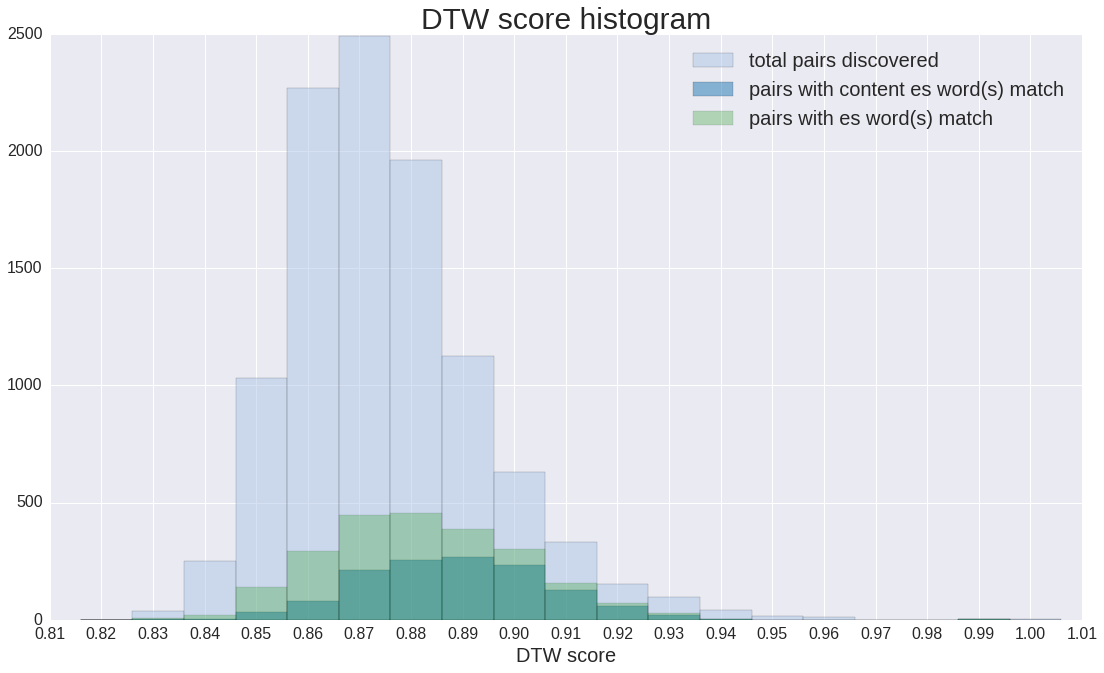

In [117]:
plot_hist_dtw(df_valid)

In [ ]:
%%timeit -n1 -r1
ch_eval.label_prop_en_words.label_spread(ch_eval.edges_dict)
print(ch_eval.edges_dict[1])
print(ch_eval.en_w_belief[1])
print(ch_eval.en_w_belief[2])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])

print(len(ch_eval.en_vocab))
print(sorted(ch_eval.en_words_stats.items(), reverse=True, key= lambda x: x[1])[:5])
print(ch_eval.en_w_sim_0[1])
print(ch_eval.label_prop_en_words.belief_0[1])
print(ch_eval.label_prop_en_words.belief_n[1])
print(ch_eval.label_prop_en_words.belief_0[2])
print(ch_eval.label_prop_en_words.belief_n[2])